In [1]:
import albumentations as A
import albumentations.pytorch
from pathlib import Path
import os

import os
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from utils import plot_sample, plot_batch, plot_with_predictions
from dataset import VCDDataset, VCDDataModule

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics as tm
from torchmetrics import Metric
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

from lightning.pytorch import Trainer, LightningModule, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from change_classifier import ChangeClassifier

import wandb

seed_everything(543)

Seed set to 543


543

In [2]:
# !python eda-venus-change-detection/download.py # to download latest version

In [3]:
root_dir = Path("/teamspace/studios/this_studio/data/VENUS_CHANGE_DATASET")

Keep the logic for generating splits now now, but we may want to create train.txt list etc to associate with the dataset

In [4]:
# List all subfolders in the root directory
subfolders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

# Define the proportions for train, val, and test sets (e.g., 70% train, 15% val, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of folders for each set
total_folders = len(subfolders)
num_train_folders = int(train_ratio * total_folders)
num_val_folders = int(val_ratio * total_folders)
num_test_folders = int(test_ratio * total_folders)

# Shuffle the list of subfolders randomly
random.shuffle(subfolders)

# Split the subfolders into train, val, and test sets
train_folders = subfolders[:num_train_folders]
val_folders = subfolders[num_train_folders:num_train_folders + num_val_folders]
test_folders = subfolders[num_train_folders + num_val_folders:]

Create the datamodule

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    num_workers = 8
    batch_size = 8
else:
    num_workers = 0
    batch_size = 4

datamodule = VCDDataModule(root_dir, train_folders, val_folders, test_folders, num_workers, batch_size)
# datamodule.prepare_data() # placeholder for downloading data
datamodule.setup()

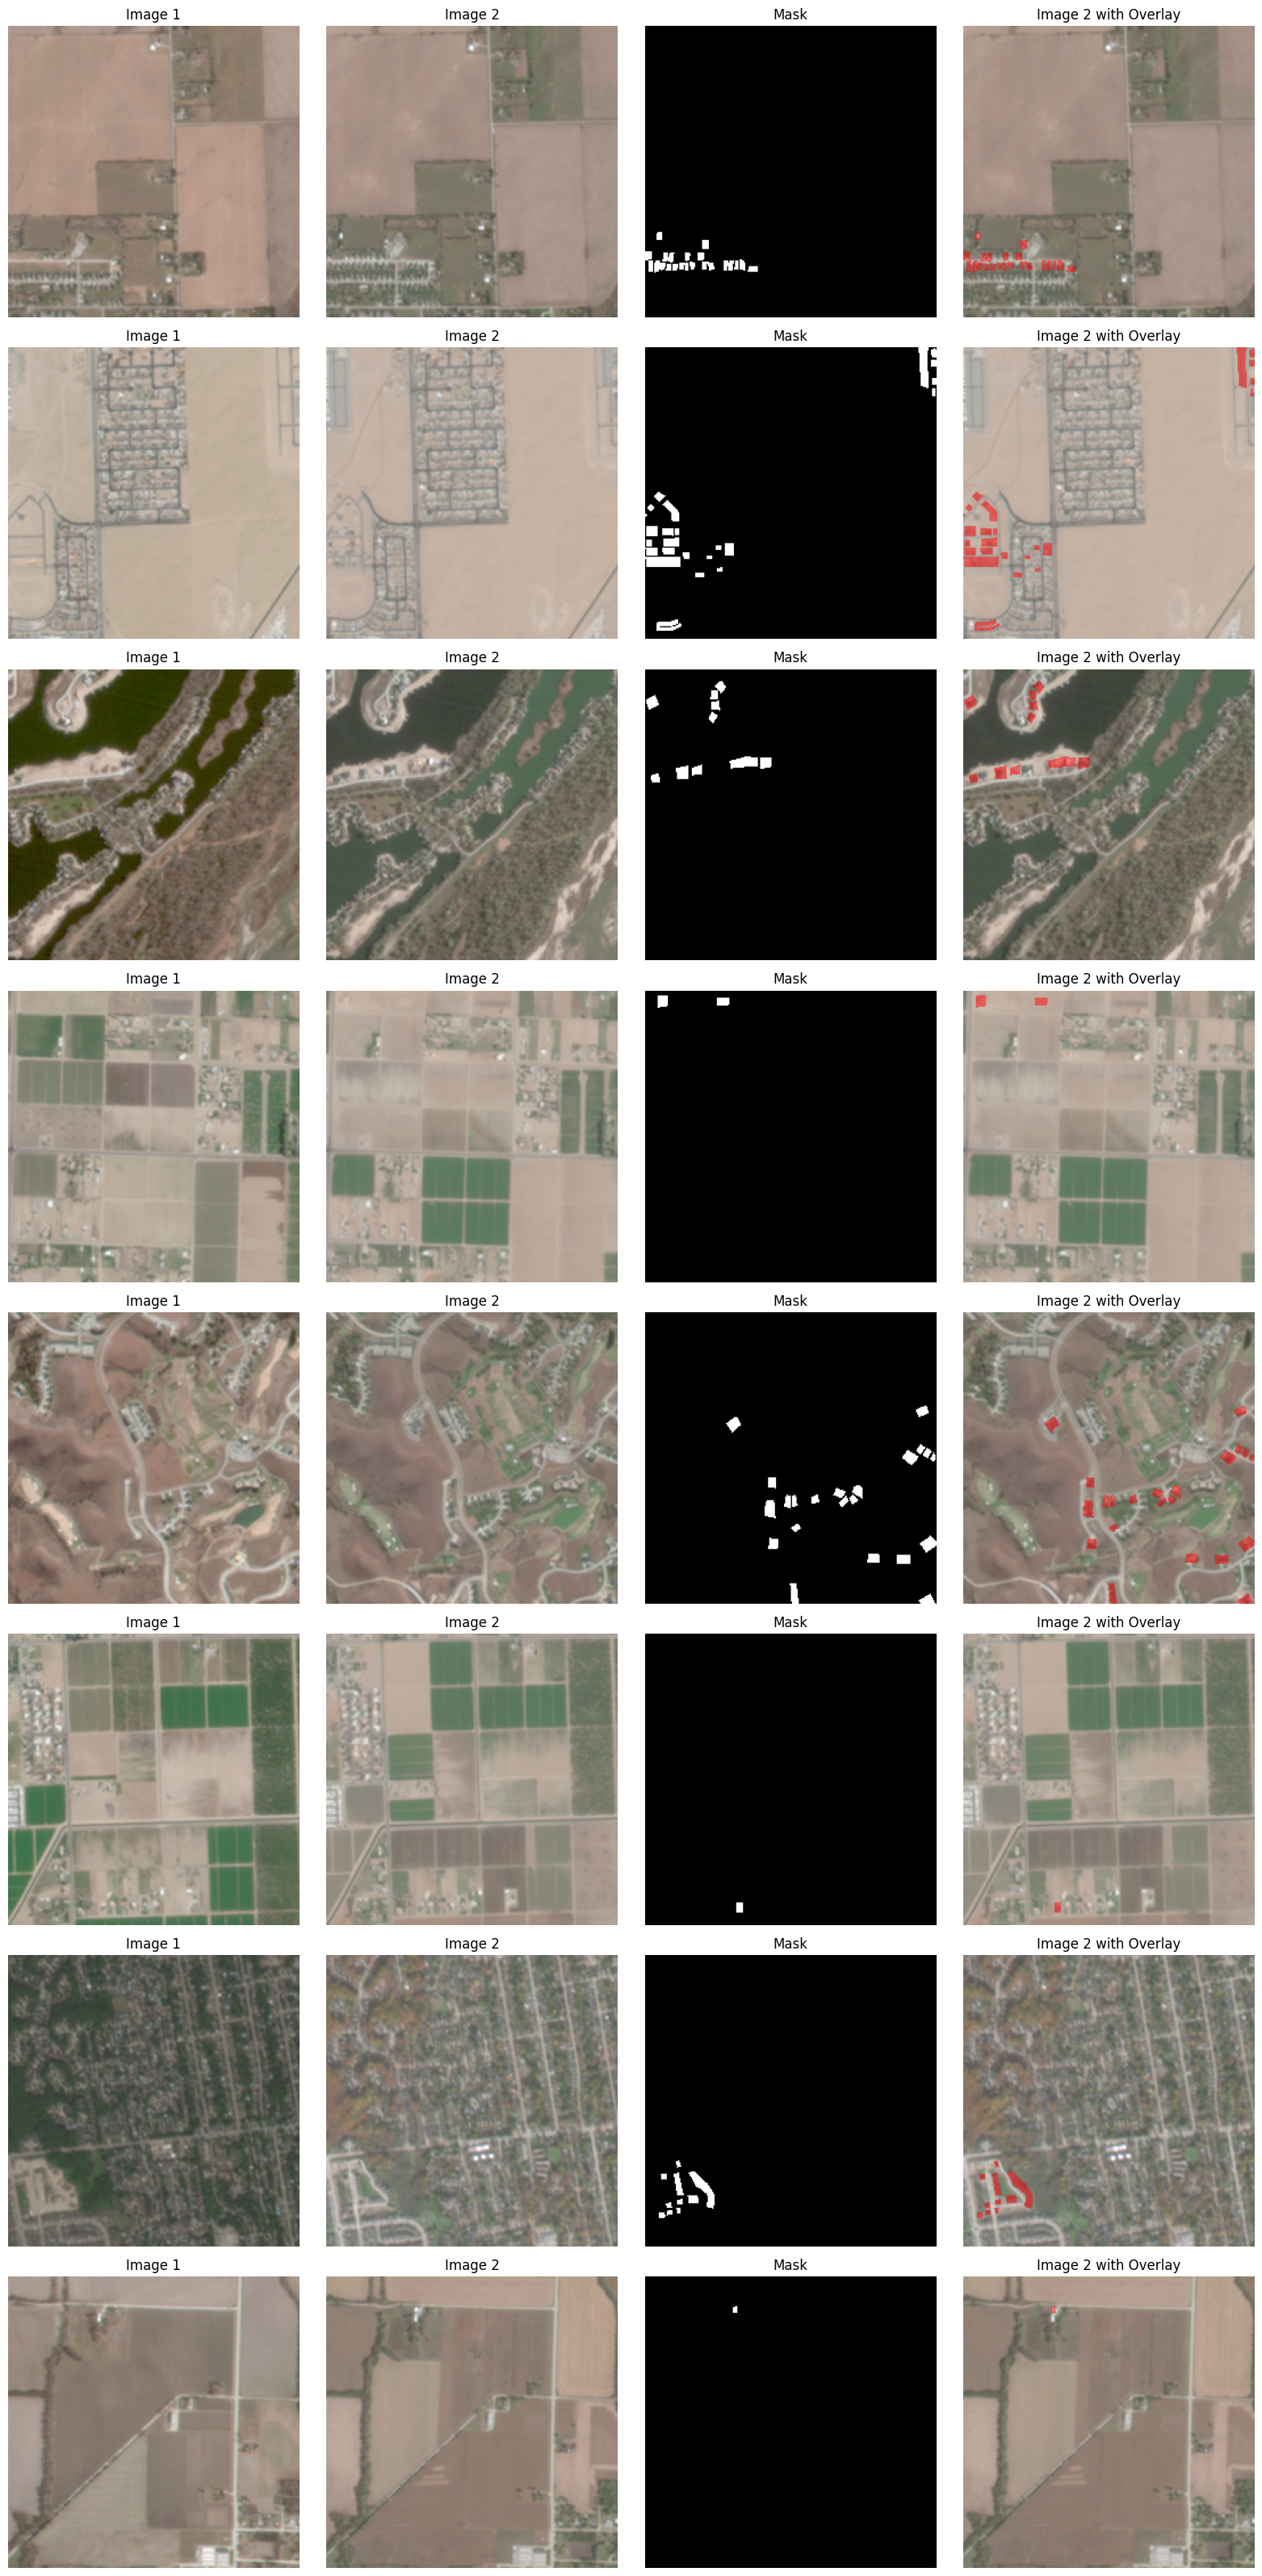

In [6]:
# View batch
batch = next(iter(datamodule.train_dataloader()))
fig = plot_batch(batch)
fig.show()

In [7]:
class ChangeDetectionTask(LightningModule):
    """
    Change Detection Task
    Setup for binary change detection
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.change_detector = ChangeClassifier(**kwargs)
        # self.criterion = torch.nn.BCELoss() # original

        weight_for_positive_class = 5
        pos_weight = torch.tensor([weight_for_positive_class])
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.save_hyperparameters()
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()

    def forward(self, reference, testimg):
        return self.change_detector(reference, testimg)

    def training_step(self, batch, batch_idx):
        y_hat = self(batch["image1"], batch["image2"])
        loss = self.criterion(y_hat, batch["mask"])
        self.log("train_loss", loss)
        self.train_f1.update(y_hat, batch["mask"])
        self.train_iou.update(y_hat, batch["mask"])
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch["image1"], batch["image2"])
        loss = self.criterion(y_hat, batch["mask"])
        self.log("val_loss", loss)
        self.val_f1.update(y_hat, batch["mask"])
        self.val_iou.update(y_hat, batch["mask"])

    def test_step(self, batch, batch_idx):
        y_hat = self(batch["image1"], batch["image2"])
        loss = self.criterion(y_hat, batch["mask"])
        self.log("test_loss", loss)
        self.test_f1.update(y_hat, batch["mask"])
        self.test_iou.update(y_hat, batch["mask"])

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=0.00356799066427741,
            weight_decay=0.009449677083344786,
            amsgrad=False,
        )
        # return {"optimizer": optimizer} # original
        scheduler = CosineAnnealingLR(optimizer, T_max=100)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def on_train_epoch_end(self):
        self.log("train_f1", self.train_f1.compute())
        self.train_f1.reset()
        self.log("train_iou", self.train_iou.compute())
        self.train_iou.reset()

    def on_validation_epoch_end(self):
        self.log("val_f1", self.val_f1.compute())
        self.val_f1.reset()
        self.log("val_iou", self.val_iou.compute())
        self.val_iou.reset()

    def on_test_epoch_end(self):
        self.log("test_f1", self.test_f1.compute())
        self.log("test_iou", self.test_iou.compute())

In [8]:
model = ChangeDetectionTask(input_channels=3)

In [9]:
# tb_logger = TensorBoardLogger("tb_logs", name="VCD")

wandb_logger = WandbLogger(
    project="VCD", 
    log_model=True, # True or 'all'
    save_dir = "wandb_logs"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=3,
)

lr_callback = LearningRateMonitor(
    logging_interval="step",
    log_momentum=True,
)

trainer = Trainer(
    min_epochs=10,
    max_epochs=500,
    callbacks=[early_stopping_callback, lr_callback],
    logger=wandb_logger,
    # precision=16
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, datamodule)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robmarkcole. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | change_detector | ChangeClassifier   | 285 K 
1 | criterion       | BCEWithLogitsLoss  | 0     
2 | train_f1        | BinaryF1Score      | 0     
3 | val_f1          | BinaryF1Score      | 0     
4 | test_f1         | BinaryF1Score      | 0     
5 | train_iou       | BinaryJaccardIndex | 0     
6 | val_iou         | BinaryJaccardIndex | 0     
7 | test_iou        | BinaryJaccardIndex | 0     
-------------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.141     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
trainer.test(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.5846257209777832     │
│         test_iou          │    0.4130537807941437     │
│         test_loss         │    0.7082500457763672     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7082500457763672,
  'test_f1': 0.5846257209777832,
  'test_iou': 0.4130537807941437}]

Regular `BCELoss`:
```
[{'test_loss': 0.020704595372080803,
  'test_f1': 0.3815913498401642,
  'test_iou': 0.23578183352947235}]
```

Using `BCEWithLogitsLoss`:
```
        weight_for_positive_class = ..
        pos_weight = torch.tensor([weight_for_positive_class])  # Set this based on your dataset imbalance.
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
```
With weighted loss weight 2,3, nothing is returned:
```
 'test_f1': 0.0, 'test_iou': 0.0
```
And 4:
```
[{'test_loss': 0.7060167193412781,
  'test_f1': 0.5197712779045105,
  'test_iou': 0.351142555475235}]
```

And 5:
```
[{'test_loss': 0.7088377475738525,
  'test_f1': 0.5612423419952393,
  'test_iou': 0.39008817076683044}]
```

And 10
```
[{'test_loss': 0.725490391254425,
  'test_f1': 0.5437141060829163,
  'test_iou': 0.37335672974586487}]
```
And 20
```
[{'test_loss': 0.7579157948493958,
  'test_f1': 0.380171000957489,
  'test_iou': 0.23469822108745575}]
```

In [12]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
lr-AdamW,███▇▇▆▆▅▄▃▂▁
lr-AdamW-momentum,▁▁▁▁▁▁▁▁▁▁▁▁
test_f1,▁
test_iou,▁
test_loss,▁
train_f1,▁▁▁▁▁▅▆▇▇▇▇▇▇██▇███████
train_iou,▁▁▁▁▁▄▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss,█▇█▃▄▇▃▆▄▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_f1,▁▁▁▁▃▆▆▇▇▇▇▇███▇▇███▇▇█


In [13]:
dl = iter(datamodule.test_dataloader())

for i in range(3):
    plot_with_predictions(next(dl), model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
